# Classifieur Random Forest 

### Chargement des données et division en features/cibles

In [1]:
import pandas as pd
import re
%matplotlib inline

In [2]:
df = pd.read_csv("../../data/prepared_data/dataset.csv")
df.head()

,machineID,datetime,error1,error2,error3,error4,error5,total_error,comp1_delay,comp2_delay,...,age,model1,model2,model3,model4,comp1,comp2,comp3,comp4,total_failure
0,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,20.0,215.0,...,18,0,0,1,0,0.0,0.0,0.0,0.0,0.0
1,1,2015-01-03 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,21.0,216.0,...,18,0,0,1,0,0.0,0.0,0.0,0.0,0.0
2,1,2015-01-04 06:00:00,1.0,0.0,1.0,0.0,1.0,3.0,22.0,217.0,...,18,0,0,1,0,0.0,0.0,0.0,0.0,0.0
3,1,2015-01-05 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,23.0,218.0,...,18,0,0,1,0,0.0,0.0,0.0,1.0,1.0
4,1,2015-01-06 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,219.0,...,18,0,0,1,0,0.0,0.0,0.0,0.0,0.0


In [3]:
models = df["model"]

In [4]:
# Labels à prédire
labels_cols = [col for col in df.columns if re.match("comp[1-4]$",col)]
Y = df[labels_cols]

# Features
drop_cols = labels_cols+["machineID", "datetime","total_failure","total_error","model"]
X = df.drop(columns=drop_cols)


### Corrélation des colonnes sur les erreurs

['error1', 'error2', 'error3', 'error4', 'error5']


<AxesSubplot:>

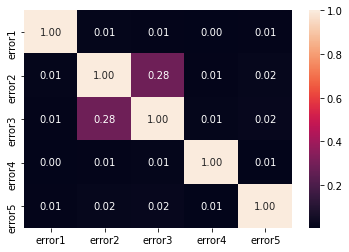

In [5]:
err_cols = [col for col in X.columns if re.match(".*error.*",col)]
print(err_cols)
import seaborn as sns
sns.heatmap(X[err_cols].corr(),annot=True,fmt=".2f")

### Entrainement du modèle

In [6]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

forest = RandomForestClassifier(random_state=1)
multi_target_forest = MultiOutputClassifier(forest)
multi_target_forest.fit(X_train, Y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=1))

### Evaluation du modèle

In [7]:
Y_pred = multi_target_forest.predict_proba(X_test)

In [9]:
import numpy as np
from sklearn import metrics
proba_select = np.arange(0,1,0.05)

confusion_matrix_1=[]
confusion_matrix_2=[]
confusion_matrix_3=[]
confusion_matrix_4=[]

for ps in proba_select:
    confusion_matrix_1.append(metrics.confusion_matrix(Y_test["comp1"],(Y_pred[0][:,1]>ps).astype(int)))
    confusion_matrix_2.append(metrics.confusion_matrix(Y_test["comp2"],(Y_pred[1][:,1]>ps).astype(int)))
    confusion_matrix_3.append(metrics.confusion_matrix(Y_test["comp3"],(Y_pred[2][:,1]>ps).astype(int)))
    confusion_matrix_4.append(metrics.confusion_matrix(Y_test["comp4"],(Y_pred[3][:,1]>ps).astype(int)))

In [10]:
false_pos_rates1 = [c[1,0]/(c[1,0]+c[1,1]) for c in confusion_matrix_1]
false_neg_rates1 = [c[0,1]/(c[0,1]+c[1,1]) for c in confusion_matrix_1]

false_pos_rates2 = [c[1,0]/(c[1,0]+c[1,1]) for c in confusion_matrix_2]
false_neg_rates2 = [c[0,1]/(c[0,1]+c[1,1]) for c in confusion_matrix_2]

<ipython-input-10-4f5882bc49d5>:2: RuntimeWarning: invalid value encountered in longlong_scalars
  false_neg_rates1 = [c[0,1]/(c[0,1]+c[1,1]) for c in confusion_matrix_1]
<ipython-input-10-4f5882bc49d5>:5: RuntimeWarning: invalid value encountered in longlong_scalars
  false_neg_rates2 = [c[0,1]/(c[0,1]+c[1,1]) for c in confusion_matrix_2]


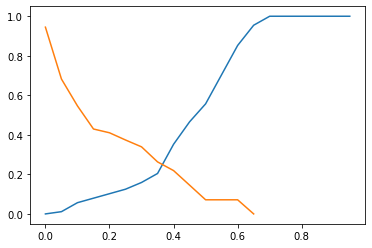

In [11]:
import matplotlib.pyplot as plt
plt.plot(proba_select,false_pos_rates1)
plt.plot(proba_select,false_neg_rates1)

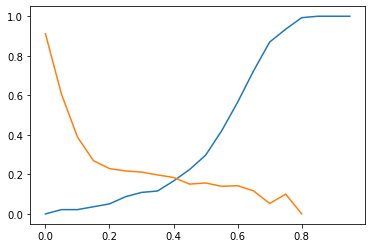

In [12]:
plt.plot(proba_select,false_pos_rates2)
plt.plot(proba_select,false_neg_rates2)

In [13]:
from sklearn import metrics

fpr1, tpr1, thresholds1 = metrics.roc_curve(Y_test["comp1"],Y_pred[0][:,1])
fpr2, tpr2, thresholds2 = metrics.roc_curve(Y_test["comp2"],Y_pred[1][:,1])
fpr3, tpr3, thresholds3 = metrics.roc_curve(Y_test["comp3"],Y_pred[2][:,1])
fpr4, tpr4, thresholds4 = metrics.roc_curve(Y_test["comp4"],Y_pred[3][:,1])

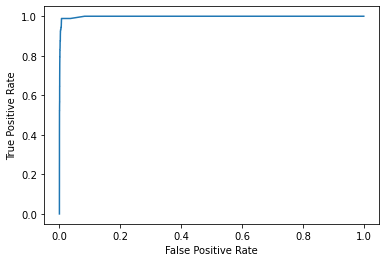

In [14]:
roc_display = metrics.RocCurveDisplay(fpr=fpr1, tpr=tpr1).plot()

In [16]:
Y_pred = multi_target_forest.predict(X_test)

from sklearn import metrics

print(metrics.confusion_matrix(Y_test["comp1"],(Y_pred[:,0]).astype(int)))
print(metrics.confusion_matrix(Y_test["comp2"],Y_pred[:,1]))
print(metrics.confusion_matrix(Y_test["comp3"],Y_pred[:,2]))
print(metrics.confusion_matrix(Y_test["comp4"],Y_pred[:,3]))

[[18159     3]
 [   49    39]]
[[18094    18]
 [   41    97]]
[[18176     5]
 [   50    19]]
[[18153     6]
 [   23    68]]


In [29]:
thresholds1

array([2.  , 1.  , 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91,
       0.9 , 0.89, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8 ,
       0.79, 0.78, 0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7 , 0.69,
       0.68, 0.67, 0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6 , 0.59, 0.58,
       0.57, 0.56, 0.55, 0.54, 0.53, 0.52, 0.51, 0.49, 0.48, 0.47, 0.46,
       0.45, 0.44, 0.43, 0.42, 0.41, 0.4 , 0.39, 0.38, 0.37, 0.36, 0.35,
       0.34, 0.33, 0.32, 0.31, 0.3 , 0.29, 0.28, 0.27, 0.26, 0.25, 0.24,
       0.23, 0.21, 0.2 , 0.19, 0.18, 0.17, 0.16, 0.15, 0.14, 0.13, 0.12,
       0.11, 0.1 , 0.09, 0.08, 0.06, 0.05, 0.04, 0.03, 0.02, 0.  ])

In [41]:
(Y_pred[0][:,1]>0.5).astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [31]:
tpr1

array([0.        , 0.95913998, 0.9828023 , 0.98895712, 0.99166277,
       0.99356291, 0.99463691, 0.99532537, 0.99591056, 0.99626167,
       0.99657836, 0.99688817, 0.9970534 , 0.99725993, 0.99748713,
       0.9976317 , 0.99781759, 0.9979897 , 0.9981687 , 0.99829262,
       0.99845785, 0.99860931, 0.9987057 , 0.99880897, 0.998926  ,
       0.99902239, 0.99909123, 0.99918073, 0.99926335, 0.99931843,
       0.99938039, 0.99940104, 0.99944235, 0.99950431, 0.99953185,
       0.99955939, 0.99957316, 0.99960069, 0.99962135, 0.99966266,
       0.99969708, 0.9997315 , 0.99974527, 0.99975904, 0.99977281,
       0.99978658, 0.99979346, 0.99981412, 0.99982789, 0.99983477,
       0.99983477, 0.99984854, 0.99985542, 0.99985542, 0.99986231,
       0.99986231, 0.99988296, 0.99988985, 0.99988985, 0.99988985,
       0.99989673, 0.9999105 , 0.99992427, 0.99992427, 0.99992427,
       0.99993115, 0.99993804, 0.99993804, 0.99994492, 0.99994492,
       0.99994492, 0.99995181, 0.99995869, 0.99997246, 0.99997

In [34]:
for  i in range(0,1,20):
    print(i)

0
